In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import ast
import os
import sys
import pymc as pm

from pathlib import Path

lib_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'lib'))
print("Lib path:", lib_path)

# Append the absolute path to sys.path
sys.path.append(lib_path)

# Now, try importing onedmodel
from onedmodel import *

Lib path: /Users/guime/projects/SLTforSGD/code/lib


In [32]:
# Plotting settings
plt.style.use('ggplot')
fig_width = 25  # figure width in cm
inches_per_cm = 0.393701               # Convert cm to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width*inches_per_cm  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
label_size = 14
tick_size = 12
params = {'backend': 'ps',
          'lines.linewidth': 1.5,
          'axes.labelsize': label_size,
          'axes.titlesize': label_size,
          'font.size': label_size,
          'legend.fontsize': tick_size,
          'xtick.labelsize': tick_size,
          'ytick.labelsize': tick_size,
          'text.usetex': False,
          'figure.figsize': fig_size,
          "font.weight": "bold",
          "axes.labelweight": "bold"}
plt.rcParams.update(params)

## Plot fraction of trajectories when escaping in 1D

In [33]:
# Initialise
nSGD = 10**3
nsamples = 10**3
shuffle = True
batch_size= 20
lr = 0.01
w0 = 2
seed_init = 1
seed_data = 1
nw0 = 2
d1 = 1
d2 = 2
wmax = nw0 * w0
frac_max = 10**-3
model = PolyModel(w0=w0, seed=seed_init, wmax=wmax, wmin=-wmax, d1=d1,d2=d2)
sgd_runner = SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, seed=seed_data, shuffle=shuffle, 
                           batch_size=batch_size, auto=True)
df = sgd_runner.generate_trajectories(model)

/Users/guime/projects/SLTforSGD/code/lib/onedmodel.py:472: RuntimeWarning: divide by zero encountered in log
  log_frac = np.log(fraction)


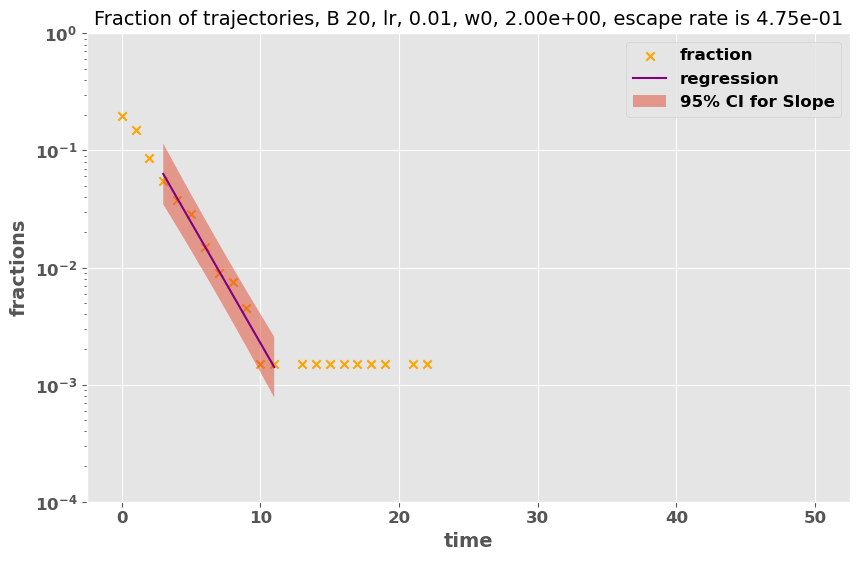

In [34]:
%matplotlib inline
trajectories = np.asarray(df['trajectory'].to_list())
clean_traj = trajectories[~np.isnan(trajectories).any(axis=1)]
fraction = regular_fraction(clean_traj, model)
escape_rate, error = compute_escape_rate(fraction, frac_max=frac_max, tmin=3,
                            batch_size=batch_size, lr=0.01, w0=w0)

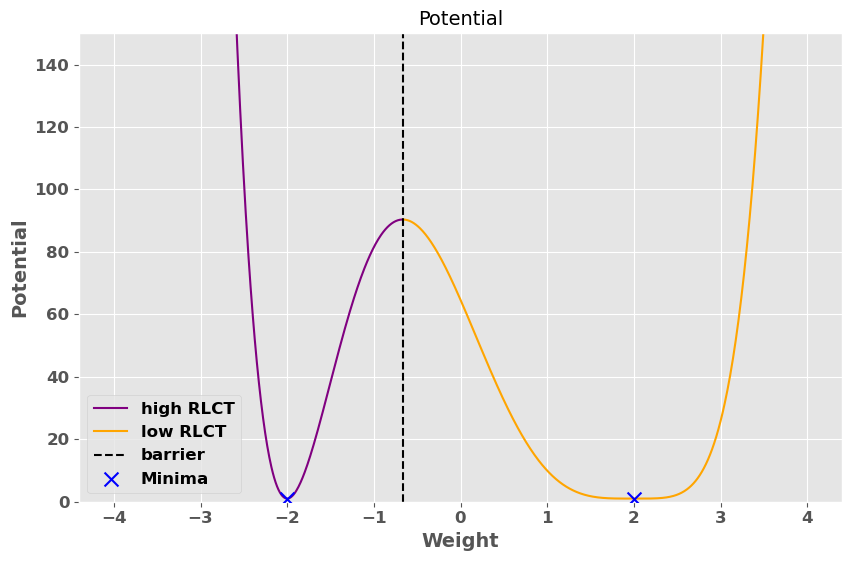

In [35]:
plot_potential(model, nsamp = 10**4, ymax = 150)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (6 chains in 1 job)
NUTS: [w]


Sampling 6 chains for 4_000 tune and 4_000 draw iterations (24_000 + 24_000 draws total) took 20 seconds.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


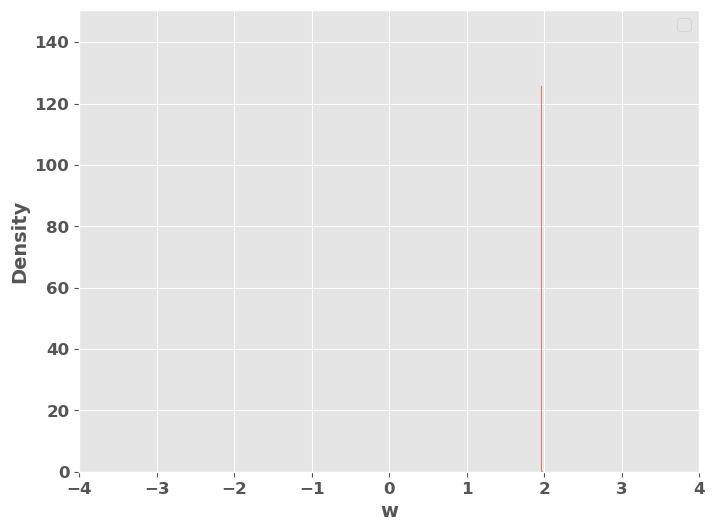

In [40]:
# Generate synthetic data
def generate_data(n_samples=1000):
    x = np.random.normal(0, 1, n_samples)
    y = np.random.normal(0, 1, n_samples)
    return x, y

# Set up the problem
n_samples = 20000
# Generate synthetic data
x, y = generate_data(n_samples=n_samples)

# Define the model using PyMC3
with pm.Model() as pmModel:
    # Prior distribution for w
    w = pm.Uniform('w', lower=-model.wmax, upper=model.wmax)
    
    # Likelihood function
    likelihood = pm.Normal('likelihood', mu=(w + model.w0)**model.d1 * (w - model.w0)**model.d2 * x, sigma=0.1, observed=y)
    
    # Perform MCMC sampling
    trace = pm.sample(4000, tune=4000, cores=1, chains=6, random_seed=42)

# Extract the sampled values of w

w_samples = trace.posterior['w'].values.flatten()

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(w_samples, bins=50, density=True, alpha=0.7)
#ax.axvline(model.w0, color='r', linestyle='--', label='Most singular')
ax.set_xlim((-wmax, wmax))
ax.set_xlabel('w')
ax.set_ylabel('Density')
ax.legend()
plt.show()

In [41]:
pm.summary(trace)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w,1.968,0.003,1.963,1.973,0.0,0.0,10063.0,14968.0,1.0


## Plot trajectories when escaping in 2D